# QuantumWormhole: QHack 2023 Open Hackathon

## Project
Implementing traversable wormhole dynamics on a quantum processor

## Team
Yellow Submarine: [Dohun Kim](https://github.com/yh08037), [Yuri Han](https://github.com/urihan)

## Summary
Implementing and reproducing the results of the paper ["Traversable wormhole dynamics on a quantum processor"](https://www.nature.com/articles/s41586-022-05424-3), Nov 2022.


## Introduction

In Nov 2022, a paper on a traversable wormhole was published in Nature. The authors aimed to build the traversable wormhole on a quantum circuit using Sachdev-Ye-Kitaev (SYK) model on Majorana fermions. The SYK model is a holographic dual of gravity, and it successfully describes the traversable wormhole dynamics. However, the considerable amount of couplings between fermions makes classical simulation challenging. The paper had a solid contribution by significantly reducing the size of the SYK model through machine learning so that it can run on a real quantum computer. Their work represents a step towards a program for studying quantum gravity in the laboratory. The result of this paper supports the ER = EPR conjecture, which states that a wormhole is equivalent to two maximally entangled black holes. Although this paper is popular and academically important, no current public code implementation exists. Therefore, our team challenged ourselves to implement a code using pennyLane for the first time through QHack 2023.

Please refer to Matthew Weiss' [blog](https://heyredhat.github.io/index.html) on quantum wormhole. 

<!-- ![Quantum Gravity](images/quantum_gravity.jpeg)  -->

## Wormhole and a quantum circuit 
To reproduce the work, our group had to first understand the connection between a quantum circuit and a traversable wormhole.

<p align="center">
<img src="images/wormhole_circuit.jpeg" alt = "image" width = "800" height = "250" title = "Nature">
</p>


From the conjecture, we now know that we have two wormholes where we can send in a message. To have a traversable wormhole where the information is kept, we first need to send the information at -t_0. Then by having a negative energy, the information survives from falling in to a singularity and return it at t1. 

<!-- The above is a spacetime diagram of the situation. We have our left half and our right half and they're entangled in the TFD state. We're imagining things traveling at the speed of light, which here is a path at 45 degrees. We act with our operator 𝑂 in the past ("message inserted") on the left black hole. It goes off, passes the left event horizon (from which there is no return, as the pull of gravity is so strong not even light can escape) and continues on until it hits the "singularity" and then it's lights out. This is just like the case we've been considering where because we're using a finite temperature TFD state or because we're swapping a message state in instead of acting with an operator--or both! In any case, there's an obstruction and so our business on the left can't go through the tube and come out on the right. -->

<!-- ### Circuit Decomposition -->
### Understanding Quantum Wormhole Teleportation Protocol

<p align="center">
<img src="images/Scrambling.jpeg" alt = "image" width = "450" height = "450" title = "Scramble Image">
</p>

To build the circuit as shown in figure c, we follow several steps: 
1. building a Thermofield Double (TFD) state 
2. SWAP gate 
3. Scrambling and perfect size winding 
4. Coupling 

Here, it is important to note that we have to read the circuit from the bottom to top. Also we want to ignore the SWAP gate on the right end as mentioned in the Nature paper.


#### TFD State 

$$ |TFD\rangle  = \frac{1}{tr(e^{\beta})} \sum_{j}^{} e^{\frac{-1}{2} \beta E_j} |\overline{E_j}\rangle |E_j\rangle $$ 


We want to use TFD state for the circuit preparation. From the equation, TFD state depends on $\beta$ and $\beta = 1/T$. When the temperature is low, the wormhole traversable is possible; however, it is not when the temperature is high instead causes time inversion. According to Matthew Weiss' blog, when $\beta = 0, |TFD\rangle = |\cup \rangle$. When the $|\cup \rangle$ is a maximally entangled state at a infinite temperature, which is a quantum teleportation, a non-gravitational teleportation, time inversion occurs. Therefore, this TFD State has a weak coupling leading to a traversable wormhole. 

#### SWAP Gate 
<!-- - need to define our left and right wormhole  -->
As mentioned, we need to have a message to go through a wormhole. In a circuit, this message would be a single qubit. By swapping this message encoded qubit with a qubit inside a left wormhole, our input qubit is ready to traverse through the wormhole. 


#### Scramble & Unscramble and Perfect Size Winding

<!-- ![scrambling](images/Scrambling.jpeg) [Scrambling] -->

After a single qubit is inserted into the left wormhole, the qubit will start to entangle with other rest of the qubits in the wormhole, called scrambling. After the information passes through the coupling process, we have to unscramble the information at the end on the right side of the wormhole. 
Therefore, we try to track how the qubit gets entangled in the scrambling step, so we use quantum mutual information as a tracker. 



#### Coupling 
Coupling is our interaction term which allows us to connect the left wormhole with our right wormhole, as shown in our circuit diagram. Here, we can transfer the qubit from left to right. Referring to our first image (a), time coupling, a green dashed line around, occurs from left to right from outside. This time coupling creates a negative energy shockwave, propagating towards the singularity. If the inserted message falls into the singularity, this means that we are going to lose the message. Therefore, the role of the negative shockwave is significant here. It will prevent information loss by falling into the singularity and deliver the message safely to the right's event horizon.


#### SYK Hamiltonian

Sachdev–Ye–Kitaev (SYK) model, or SYK Hamiltonian is a system that is holographically dual to gravity. Successful teleportation is described from the dual gravity perspective as a particle traveling through a traversable wormhole. It is a sum of $q$ way interactions between Majorana fermions $\psi^j$, and the coefficients $J_j$ follows Gaussian distribution. 

![syk](images/fig_syk_hamiltonian.png)

However, experimentally implementing a full SYK model is extremely challenging. Therefore, the authors applied the machine learning approach to reduce the size of SYK Hamiltonian while preserving the gravitational physics. As a result, authors obtained a sparsified SYK Hamiltonian which has only five terms. The authors claim that the learned Hamiltonian reproduces gravitational dynamics of the SYK model.

In [4]:
import pennylane as qml

worm_wires = list(range(7))
msg_wires = [7, 8]

wires = msg_wires + worm_wires
dev = qml.device('lightning.gpu', wires=len(wires), shots=None)

In [5]:
# q=4 Majorana basis for left system
basis_L = [
    ('L1', 'L2', 'L4', 'L5'), 
    ('L1', 'L3', 'L4', 'L7'), 
    ('L1', 'L3', 'L5', 'L6'), 
    ('L2', 'L3', 'L4', 'L6'), 
    ('L2', 'L3', 'L5', 'L7')
]

# q=4 Majorana basis for right system
basis_R = [
    ('R1', 'R2', 'R4', 'R5'), 
    ('R1', 'R3', 'R4', 'R7'), 
    ('R1', 'R3', 'R5', 'R6'), 
    ('R2', 'R3', 'R4', 'R6'), 
    ('R2', 'R3', 'R5', 'R7'),
]

# Majorana basis for coupling term
basis_V = [
    ('L1', 'R1'),
    ('L2', 'R2'),
    ('L3', 'R3'),
    ('L4', 'R4'),
    ('L5', 'R5'),
    ('L6', 'R6'),
    ('L7', 'R7'),
]

# Coefficient of sparsified SYK Hamiltonian
coeff = [-0.36, 0.19, -0.71, 0.22, 0.49]

We defined the basis relationships for the systems left black hole, right black hole, and coupling. However, we need to know what $\psi_L^j$ and $\psi_R^j$ are in order to calculate the basis exactly. 

### Majorana Fermions

In the previous section, authors reduced the $N=10$ dense SYK model to $N=7$ sparsified SYK model. To encode 7 Majorana fermions for the left black hole and 7 Majorana fermions for the right black hole, we require 7 qubits (two fermions per qubit). The authors decided to use standard Jordan-Wigner transformation to encode the Majorana fermions in the Hamiltonian. To make the decomposition of Majorana swap gates efficient, $\psi_L^1=ZX$, $\psi_L^2=ZY$, $\psi_R^1=X$, $\psi_R^2=Y$ are particularly chosen. The remaining transformations are chosen to satisfy $\psi_R^i\psi_L^j=\frac{i}{2}Z$ for shallow Trotterization of the coupling term $e^{i\mu V}$.

![majorana](images/fig_majorana.png)


Here, $Z^i$ indicates $Z\otimes Z\otimes\cdots\otimes Z$ over $i$ Paulis. Note that every Majorana fermions $\psi$ satistisfy the anticommutation rule $\{\psi^i, \psi^j\}=\delta_{ij}$. Now, let's define this majorana fermions as a set of Pauli words, then calculate the hamiltonian of our system.

In [6]:
# Jordan-Wigner Transformation for Majorana Fermions
psi_map = {
    'L1': 'ZXIIIII',
    'L2': 'ZYIIIII',
    'L3': 'ZZZZZXI',
    'L4': 'ZZXIIII',
    'L5': 'ZZZZXII',
    'L6': 'ZZZXIII',
    'L7': 'ZZZZZZX',
    'R1': 'XIIIIII',
    'R2': 'YIIIIII',
    'R3': 'ZZZZZYI',
    'R4': 'ZZYIIII',
    'R5': 'ZZZZYII',
    'R6': 'ZZZYIII',
    'R7': 'ZZZZZZY'    
}

In [7]:
def pauli_word(word):
    ''' convert pauli string to `qml.pauli.PauliWord` '''
    pw = qml.pauli.PauliWord({i: p for i, p in zip(worm_wires, word)})
    return pw

def mult_pauli_words(word_list, ignore_phase=False):
    ''' calculate cumulative multiplication of pauli words '''
    assert len(word_list) > 1
    word, phase = pauli_word(word_list[0]), 1
    for w in word_list[1:]:
        word, new_phase = word * pauli_word(w)
        if not ignore_phase:
            phase = phase * new_phase
    return word, phase

def majorana_basis(psi, terms):
    ''' calculate the set of majorana basis '''
    word_list_list = [[psi[key] for key in term] for term in terms]
    basis_list = [mult_pauli_words(word_list) for word_list in word_list_list]
    return basis_list

def pauli_sentence(words, coeff, premult_i=False, mult=1.):
    ''' caculate pauli sentence from pauli word list and coefficients '''
    ps = qml.pauli.PauliSentence({
        word: (1j*p if premult_i else p).real * c * mult
        for (word, p), c in zip(words, coeff)
    })
    return ps

In [8]:
# hamiltonian of left system
m_L = majorana_basis(psi_map, basis_L)
ps_L = pauli_sentence(m_L, coeff, mult=0.25)
H_L = ps_L.hamiltonian(wire_order=worm_wires)

# hamiltonian of right system
m_R = majorana_basis(psi_map, basis_R)
ps_R = pauli_sentence(m_R, coeff, mult=0.25)
H_R = ps_R.hamiltonian(wire_order=worm_wires)

# hamiltonian of coupling term
m_V = majorana_basis(psi_map, basis_V)
ps_iV = pauli_sentence(m_V, [1/28]*7, premult_i=True, mult=0.5)
i_H_V = ps_iV.hamiltonian(wire_order=worm_wires)

### Dirac Fermions & SWAP gate

To swap a qubit into or out of the wormhole, authors paired up Majorana fermions on a single qubit into a Dirac fermion 
$$\chi_{L, R}=\frac{1}{\sqrt{2}}\left( \psi_{L, R}^1 + i \psi_{L, R}^2 \right) \\ \Rightarrow \chi_L=\frac{1}{2}(ZX+iZY), \ \chi_R=\frac{1}{2}(X+iY).$$
The swap gate is then given by
$$ \mathrm{SWAP} = \begin{bmatrix} 
\chi\chi^\dagger & \chi  \\ 
\chi & \chi^\dagger\chi
\end{bmatrix} $$
thus,
$$ \mathrm{SWAP}_{X+iY} = \begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & 0 & 1 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 0 & 1 
\end{bmatrix}, \quad \mathrm{SWAP}_{ZX+iZY} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}. $$ 
Since the $\mathrm{SWAP}_{X+iY}$ coincides with the standard swap gate, the final swap in the protocol from R to T (Fig. 1c of the paper) is replaced by direct measurement of the rightmost qubit of R to reduce gate count.

In [98]:
def dirac_fermion(word_1, word_2):
    assert len(word_1) == len(word_2)
    chi = pauli_sentence(
        [(pauli_word(word_1), 1), (pauli_word(word_2), 1)], [1/2, 1j/2]
    ).to_mat(wire_order=range(len(word_1)))
    return chi

chi_L = dirac_fermion('ZX', 'ZY')
chi_R = dirac_fermion('X', 'Y')

In [99]:
import pennylane.numpy as np

def fermion_swap(chi):
    chi_dag = chi.conj().transpose()
    mat_swap = np.block([
        [chi @ chi_dag, chi_dag],
        [chi, chi_dag @ chi]
    ])
    return mat_swap

SWAP_L = fermion_swap(chi_L)
SWAP_R = fermion_swap(chi_R)

In [100]:
def swap_zxizy(wires):
    qml.QubitUnitary(
        np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, -1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1] 
        ], requires_grad=False),
        wires=wires
    )

### Coupling (Interaction) Term

$$ \text{Coupling term: } e^{i\mu V} \ \mathrm{where} \ V = \dfrac{1}{qN} \sum_j \psi_L^j \psi_R^j$$

In [102]:
def eiuV_matrix(mu):
    eiuV = qml.exp(ps_iV.operation(wire_order=worm_wires), mu)
    return eiuV.matrix(wire_order=worm_wires)

def coupling(mu, wires):
    qml.QubitUnitary(eiuV_matrix(mu), wires=wires)

### TFD state preparation
To prepare the exact TFD state, we need to decompose the total hamiltonian into energy states, but is it not a scalable method to the number of fermions. To this end, the authors deciced to apply a hardware efficient variational quantum eigensolver (VQE). Previous works showed that the ground state of the hamiltonian $H_{TFD} = H_L + H_R + i\nu V$ is approximately the thermofield double state.

In [191]:
# exact eigen solver
nu = 4

mat_LR = (ps_L + ps_R).to_mat(wire_order=worm_wires)
mat_V = ps_iV.to_mat(wire_order=worm_wires)
mat_TFD = mat_LR + nu * mat_V

w, v = np.linalg.eig(mat_TFD)
ground_state = v[np.argmin(w.real)]
ground_energy = np.min(w.real)

print('exact groung energy: ', ground_energy)

exact groung energy:  -1.0390922052275189


We used `qml.StronglyEntanglingLayers` as a circuit ansatz for VQE.

In [175]:
# parameter initialization
shape = qml.StronglyEntanglingLayers.shape(n_layers=4, n_wires=len(worm_wires))
params = np.random.random(size=shape)

# circuit ansatz
@qml.qnode(dev)
def vqe_ansatz(params, hamiltonian):
    qml.StronglyEntanglingLayers(params, wires=worm_wires)
    return qml.expval(hamiltonian)

In [176]:
opt = qml.AdamOptimizer()
n_iter = 1000
energy_list = []

# TFD Hamiltonian
H_TFD = H_L + H_R + nu * i_H_V

# The optimizing loop for the VQE
for it in range(n_iter):
    params, cost = opt.step_and_cost(
        lambda p: vqe_ansatz(p, H_TFD), params
    )
    energy_list.append(cost)
    if it % 100 == 0:
        print(f'{it:4d} {cost:.4f}')

   0 -0.1120
 100 -0.5574
 200 -0.5908
 300 -0.5913
 400 -0.6016
 500 -0.6017
 600 -0.6792
 700 -1.0189
 800 -1.0208
 900 -1.0208


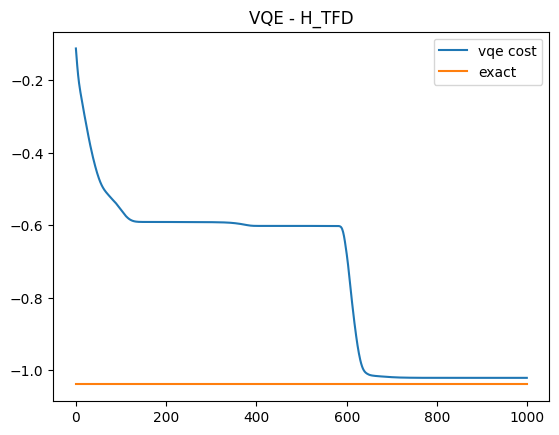

In [194]:
import matplotlib.pyplot as plt

plt.plot(energy_list, label='vqe cost')
plt.plot([ground_energy]*len(energy_list), label='exact')
plt.title('VQE - H_TFD')
plt.legend()
plt.show()

### Wormhole Teleportation Circuit Implementation

In [179]:
@qml.qnode(dev)
def circuit(t0, t1, mu):    
    # TFD state preparation by VQE    
    qml.StronglyEntanglingLayers(params, wires=worm_wires)
    
    # P & Q cup state preparation
    qml.Hadamard(wires=msg_wires[0])
    qml.CNOT(wires=msg_wires)
    
    # throw input state in the past!
    qml.exp(H_L, 1j*t0)
    swap_zxizy(wires=[msg_wires[1], worm_wires[0], worm_wires[1]])
    qml.exp(H_L, -1j*t0)
    
    # coupling term, unwinding
    coupling(mu, wires=worm_wires)
    
    # unscrambling
    qml.exp(H_R, -1j*t1)
    
    return qml.density_matrix(wires=[msg_wires[0], worm_wires[0]])

In [180]:
def mutual_info(rho):
    rho = rho / np.trace(rho)
    info = qml.math.mutual_info(rho, [0], [1])
    return info

In [181]:
t_list = np.linspace(0, 10, 30, requires_grad=False)

mutal_info_neg = [mutual_info(circuit(t, t, -12)) for t in t_list]
mutal_info_pos = [mutual_info(circuit(t, t, 12)) for t in t_list]

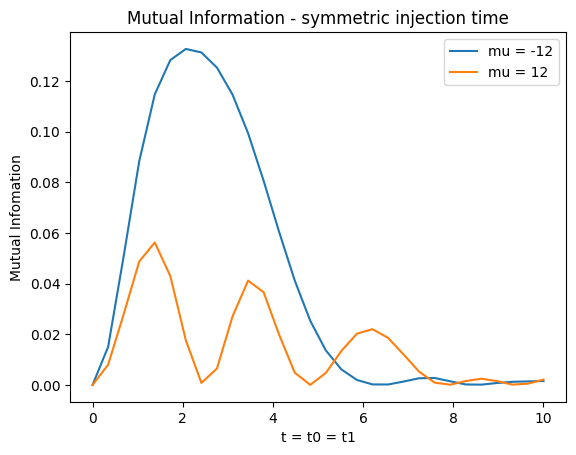

In [199]:
plt.plot(t_list, mutal_info_neg, label='mu = -12')
plt.plot(t_list, mutal_info_pos, label='mu = 12')
plt.title('Mutual Information - symmetric injection time')
plt.xlabel('t = t0 = t1')
plt.ylabel('Mutual Infomation')
plt.legend()
plt.show()

In [183]:
t1_space = np.linspace(0, 10, 30, requires_grad=False)

asym_mutal_info_neg = [mutual_info(circuit(2.8, t, -12)) for t in t1_space]
asym_mutal_info_pos = [mutual_info(circuit(2.8, t, 12)) for t in t1_space]
asym_mutal_info_diff = [neg - pos for neg, pos in zip(asym_mutal_info_neg, asym_mutal_info_pos)]

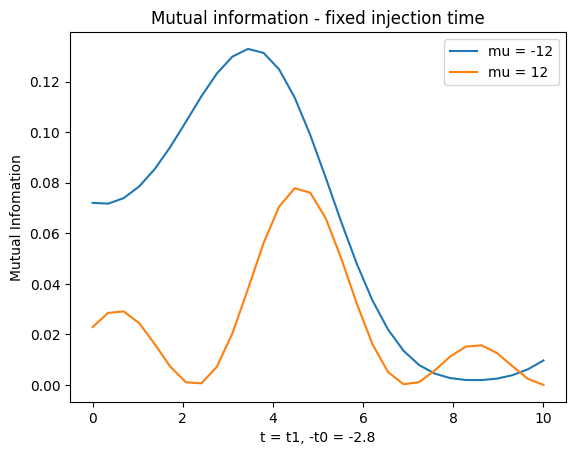

In [200]:
plt.plot(t1_space, asym_mutal_info_neg, label='mu = -12')
plt.plot(t1_space, asym_mutal_info_pos, label='mu = 12')
plt.title('Mutual information - fixed injection time')
plt.xlabel('t = t1, -t0 = -2.8')
plt.ylabel('Mutual Infomation')
plt.legend()
plt.show()

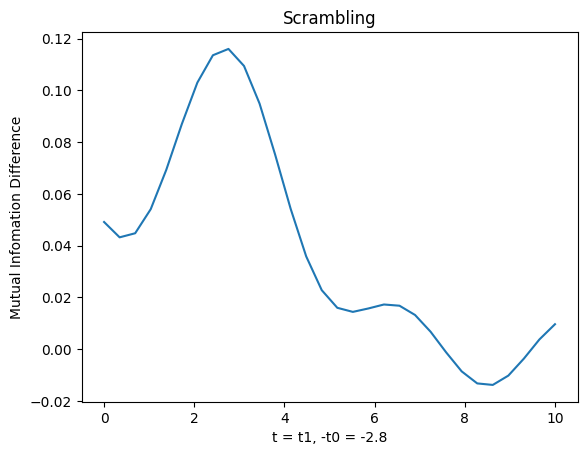

In [202]:
plt.plot(t1_space, asym_mutal_info_diff)
plt.title('Scrambling')
plt.xlabel('t = t1, -t0 = -2.8')
plt.ylabel('Mutual Infomation Difference')
plt.show()

## Conclusion & Future Works
In this project, we implemented the traversable wormhole teleportation protocol with PennyLane, and reproduced some results on the paper ["Traversable wormhole dynamics on a quantum processor"](https://www.nature.com/articles/s41586-022-05424-3). It is significant that this project is the first code implementation for the this paper. We plan to conduct more experiments from papers such as perfect size winding, thermalizaiton, and Shapiro time delay.

**Note)** Due to our short background knowledge about Astrophysics and wormhole dynamics, our implementation or experiments may include mistakes. We look forward to get comments from the experts of this research area. Any criticisms or comments are welcomed.